# Moment Prediction with LSTM using Leave-One-Subject-Out (LOSO) Cross-Validation

This notebook implements a machine learning pipeline to predict knee and ankle moments from 6-axis accelerometer data. 

### Workflow:
1.  **Subject Selection**: A specific subject is chosen to be the 'left-out' test set.
2.  **Data Loading**: The model loads data from all other subjects to form the training set.
3.  **Preprocessing**: A `MinMaxScaler` is fitted **only on the training set** to prevent data leakage. Both training and test sets are then scaled and shaped into sequences for the LSTM.
4.  **Model Training**: A bidirectional LSTM model is trained on the training data, using a subset for validation to prevent overfitting (Early Stopping).
5.  **Model Saving**: The best trained model is saved in both PyTorch (`.pth`) and ONNX (`.onnx`) formats.
6.  **Evaluation**: The model is evaluated on the held-out test subject, and the predictions are saved to a CSV file for analysis.

### 1. Setup and Imports

In [1]:
# Import libraries and set up environment
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.onnx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import os
import random

# --- CHOOSE THE SUBJECT TO LEAVE OUT ---
SUBJECT_TO_LEAVE_OUT = 9 # Change this value to select a different subject (e.g., 1 to 10)
DATA_DIR = 'data' # Set the path to your data directory

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f'Leaving out subject: {SUBJECT_TO_LEAVE_OUT}')

Using device: cuda
Leaving out subject: 9


### 2. Data Loading for LOSO

In [2]:
def load_loso_data(subject_to_leave_out, data_dir):
    '''Loads data based on the Leave-One-Subject-Out principle.'''
    train_trials = []
    test_trials = []
    all_subjects = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d.startswith('subj')]

    for subj_folder in tqdm(all_subjects, desc='Loading Subject Data'):
        subj_id = int(subj_folder.replace('subj', ''))
        subj_path = os.path.join(data_dir, subj_folder)

        try:
            # Inputs (Accelerations)
            l_knee_x = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_LLML_Acc_axis1.csv'))
            l_knee_y = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_LLML_Acc_axis2.csv'))
            l_knee_z = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_LLML_Acc_axis3.csv'))
            r_knee_x = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_RLML_Acc_axis1.csv'))
            r_knee_y = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_RLML_Acc_axis2.csv'))
            r_knee_z = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_RLML_Acc_axis3.csv'))
            # Outputs (Moments) - Using axis2 as in the original notebook
            l_moment = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_left_knee_moment_axis2.csv'))
            r_moment = pd.read_csv(os.path.join(subj_path, f'subj{subj_id}_right_knee_moment_axis2.csv'))
        except FileNotFoundError as e:
            print(f'Skipping subject {subj_id} due to missing file: {e}')
            continue

        n_trials = l_knee_x.shape[1]
        for trial in range(n_trials):
            acc_data = np.stack([
                l_knee_x.iloc[:, trial], l_knee_y.iloc[:, trial], l_knee_z.iloc[:, trial],
                r_knee_x.iloc[:, trial], r_knee_y.iloc[:, trial], r_knee_z.iloc[:, trial]
            ], axis=1) # Shape: (timesteps, 6)
            moment_data = np.stack([
                l_moment.iloc[:, trial], r_moment.iloc[:, trial]
            ], axis=1) # Shape: (timesteps, 2)

            # Allocate to train or test set
            if subj_id == subject_to_leave_out:
                test_trials.append((acc_data, moment_data))
            else:
                train_trials.append((acc_data, moment_data))

    print(f'Data loaded.')
    print(f'{len(train_trials)} trials in the training set.')
    print(f'{len(test_trials)} trials in the test set.')
    return train_trials, test_trials

train_trial_data, test_trial_data = load_loso_data(SUBJECT_TO_LEAVE_OUT, DATA_DIR)

Loading Subject Data:   0%|          | 0/10 [00:00<?, ?it/s]

Data loaded.
291 trials in the training set.
33 trials in the test set.


### 3. Data Preprocessing for LOSO

This section defines two functions:
1. `create_sequences`: This function takes time-series data and converts it into overlapping sequences, which is the required input format for an LSTM model.
2. `preprocess_loso_data`: This is the main preprocessing pipeline. It takes the raw training and testing trials and performs several key steps:
    - **Scaler Fitting**: It fits a `MinMaxScaler` on the **training data only**. This is critical to prevent data leakage.
    - **Data Scaling**: It uses the fitted scaler to transform both the training and test data.
    - **Sequence Generation**: It calls `create_sequences` to prepare the data for the LSTM model.
    - **Dataset Splitting**: It splits the processed training data into a final training set (85%) and a validation set (15%). The test data is kept separate.

In [3]:
def create_sequences(features, targets, seq_length, step=1):
    """Creates overlapping sequences and corresponding targets for a single trial."""
    sequences = []
    target_seq = []
    for i in range(0, len(features) - seq_length + 1, step):
        sequences.append(features[i:i + seq_length])
        target_seq.append(targets[i + seq_length - 1])  # Target is the last timestep
    return np.array(sequences), np.array(target_seq)

def preprocess_loso_data(train_trials, test_trials, seq_length=100, step=1):
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Step 1: Fit scalers on TRAINING data only
    print('Fitting scalers on training data...')
    all_train_features = np.concatenate([d[0] for d in train_trials])
    all_train_targets = np.concatenate([d[1] for d in train_trials])
    feature_scaler.fit(all_train_features)
    target_scaler.fit(all_train_targets)
    del all_train_features, all_train_targets # Free memory

    # Step 2: Process training data
    all_train_feature_sequences = []
    all_train_target_sequences = []
    for acc_data, moment_data in tqdm(train_trials, desc="Processing Train Trials"):
        features_scaled = feature_scaler.transform(acc_data)
        targets_scaled = target_scaler.transform(moment_data)
        X_seq, y_seq = create_sequences(features_scaled, targets_scaled, seq_length, step)
        all_train_feature_sequences.append(X_seq)
        all_train_target_sequences.append(y_seq)

    X_train_val = np.concatenate(all_train_feature_sequences, axis=0)  # Shape: (n_sequences, seq_length, 6)
    y_train_val = np.concatenate(all_train_target_sequences, axis=0)  # Shape: (n_sequences, 2)
    del all_train_feature_sequences, all_train_target_sequences # Free memory

    # Step 3: Process test data
    all_test_feature_sequences = []
    all_test_target_sequences = []
    for acc_data, moment_data in tqdm(test_trials, desc="Processing Test Trials"):
        features_scaled = feature_scaler.transform(acc_data)
        targets_scaled = target_scaler.transform(moment_data)
        X_seq, y_seq = create_sequences(features_scaled, targets_scaled, seq_length, step)
        all_test_feature_sequences.append(X_seq)
        all_test_target_sequences.append(y_seq)

    X_test = np.concatenate(all_test_feature_sequences, axis=0)
    y_test = np.concatenate(all_test_target_sequences, axis=0)
    del all_test_feature_sequences, all_test_target_sequences # Free memory

    # Step 4: Convert to PyTorch Tensors and create Datasets
    train_val_dataset = TensorDataset(torch.tensor(X_train_val, dtype=torch.float32), torch.tensor(y_train_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    # Step 5: Split training data into train and validation sets (85/15 split)
    train_size = int(0.85 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

    print(f'Total training sequences: {len(train_dataset)}')
    print(f'Total validation sequences: {len(val_dataset)}')
    print(f'Total test sequences: {len(test_dataset)}')

    return train_dataset, val_dataset, test_dataset, feature_scaler, target_scaler

# Execute preprocessing
seq_length = 100
step = 1
train_dataset, val_dataset, test_dataset, feature_scaler, target_scaler = preprocess_loso_data(train_trial_data, test_trial_data, seq_length, step)

Fitting scalers on training data...


Processing Train Trials:   0%|          | 0/291 [00:00<?, ?it/s]

Processing Test Trials:   0%|          | 0/33 [00:00<?, ?it/s]

Total training sequences: 1755937
Total validation sequences: 309872
Total test sequences: 234267


### 4. DataLoader Creation

In [4]:
# Create PyTorch DataLoaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

print(f'Created DataLoaders with batch size {batch_size}')

Created DataLoaders with batch size 1024


### 5. Model Definition

In [5]:
# --- Model Definition ---
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(AdvancedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_prob if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, : ]
        out = self.dropout(last_time_step_out)
        out = self.fc(out)
        return out

print('Model class defined.')

Model class defined.


### 6. Model Hyperparameters and Initialization

In [6]:
# --- Model Hyperparameters ---
INPUT_SIZE = 6  # 6 acceleration channels
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 2  # LY and RY moments
DROPOUT_PROB = 0.3
LEARNING_RATE = 0.0003
NUM_EPOCHS = 50

# Clear CUDA memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Initialize the model
model = AdvancedLSTMModel(
    INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB
    ).to(device)

print(f'Model Architecture Initialized:{model}')

Model Architecture Initialized:AdvancedLSTMModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


### 7. Training with Early Stopping

In [7]:
# --- Training with Early Stopping ---
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Added L2 regularization
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': []}

num_train_batches = len(train_loader)
num_val_batches = len(val_loader)

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [T]', leave=False)
    for seq, labels in train_pbar:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / num_train_batches
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [V]', leave=False)
    for seq, labels in val_pbar:
        seq, labels = seq.to(device), labels.to(device)
        with torch.no_grad():
            y_val_pred = model(seq)
            val_loss = criterion(y_val_pred, labels)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / num_val_batches
    history['val_loss'].append(avg_val_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break

# --- Save the Best Model ---
if best_model_state is not None:
    model_path_pth = f'model_without_subj_{SUBJECT_TO_LEAVE_OUT}.pth'
    torch.save(best_model_state, model_path_pth)
    print(f'Best model saved to {model_path_pth}')
    # Load the best performing model for final evaluation
    model.load_state_dict(best_model_state)
else:
    print('Training did not improve, no model saved.')

Epoch 1/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 1/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 1/50 -> Train Loss: 0.010358, Val Loss: 0.000739


Epoch 2/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 2/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 2/50 -> Train Loss: 0.002556, Val Loss: 0.000697


Epoch 3/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 3/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 3/50 -> Train Loss: 0.002131, Val Loss: 0.000703


Epoch 4/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 4/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 4/50 -> Train Loss: 0.001653, Val Loss: 0.000663


Epoch 5/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 5/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 5/50 -> Train Loss: 0.001169, Val Loss: 0.000663


Epoch 6/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 6/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 6/50 -> Train Loss: 0.000862, Val Loss: 0.000655


Epoch 7/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 7/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 7/50 -> Train Loss: 0.000725, Val Loss: 0.000660


Epoch 8/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 8/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 8/50 -> Train Loss: 0.000676, Val Loss: 0.000651


Epoch 9/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 9/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 9/50 -> Train Loss: 0.000662, Val Loss: 0.000651


Epoch 10/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 10/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 10/50 -> Train Loss: 0.000658, Val Loss: 0.000646


Epoch 11/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 11/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 11/50 -> Train Loss: 0.000656, Val Loss: 0.000656


Epoch 12/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 12/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 12/50 -> Train Loss: 0.000654, Val Loss: 0.000645


Epoch 13/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 13/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 13/50 -> Train Loss: 0.000653, Val Loss: 0.000656


Epoch 14/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 14/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 14/50 -> Train Loss: 0.000651, Val Loss: 0.000649


Epoch 15/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 15/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 15/50 -> Train Loss: 0.000650, Val Loss: 0.000642


Epoch 16/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 16/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 16/50 -> Train Loss: 0.000648, Val Loss: 0.000639


Epoch 17/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 17/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 17/50 -> Train Loss: 0.000646, Val Loss: 0.000638


Epoch 18/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 18/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 18/50 -> Train Loss: 0.000645, Val Loss: 0.000640


Epoch 19/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 19/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 19/50 -> Train Loss: 0.000643, Val Loss: 0.000632


Epoch 20/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 20/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 20/50 -> Train Loss: 0.000640, Val Loss: 0.000640


Epoch 21/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 21/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 21/50 -> Train Loss: 0.000639, Val Loss: 0.000635


Epoch 22/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 22/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 22/50 -> Train Loss: 0.000638, Val Loss: 0.000630


Epoch 23/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 23/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 23/50 -> Train Loss: 0.000637, Val Loss: 0.000633


Epoch 24/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 24/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 24/50 -> Train Loss: 0.000636, Val Loss: 0.000631


Epoch 25/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 25/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 25/50 -> Train Loss: 0.000635, Val Loss: 0.000628


Epoch 26/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 26/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 26/50 -> Train Loss: 0.000633, Val Loss: 0.000630


Epoch 27/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 27/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 27/50 -> Train Loss: 0.000632, Val Loss: 0.000623


Epoch 28/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 28/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 28/50 -> Train Loss: 0.000629, Val Loss: 0.000621


Epoch 29/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 29/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 29/50 -> Train Loss: 0.000627, Val Loss: 0.000619


Epoch 30/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 30/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 30/50 -> Train Loss: 0.000626, Val Loss: 0.000620


Epoch 31/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 31/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 31/50 -> Train Loss: 0.000625, Val Loss: 0.000623


Epoch 32/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 32/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 32/50 -> Train Loss: 0.000623, Val Loss: 0.000615


Epoch 33/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 33/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 33/50 -> Train Loss: 0.000622, Val Loss: 0.000614


Epoch 34/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 34/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 34/50 -> Train Loss: 0.000622, Val Loss: 0.000618


Epoch 35/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 35/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 35/50 -> Train Loss: 0.000621, Val Loss: 0.000614


Epoch 36/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 36/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 36/50 -> Train Loss: 0.000620, Val Loss: 0.000624


Epoch 37/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 37/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 37/50 -> Train Loss: 0.000620, Val Loss: 0.000613


Epoch 38/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 38/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 38/50 -> Train Loss: 0.000619, Val Loss: 0.000613


Epoch 39/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 39/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 39/50 -> Train Loss: 0.000619, Val Loss: 0.000625


Epoch 40/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 40/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 40/50 -> Train Loss: 0.000619, Val Loss: 0.000611


Epoch 41/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 41/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 41/50 -> Train Loss: 0.000618, Val Loss: 0.000614


Epoch 42/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 42/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 42/50 -> Train Loss: 0.000617, Val Loss: 0.000612


Epoch 43/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 43/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 43/50 -> Train Loss: 0.000617, Val Loss: 0.000609


Epoch 44/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 44/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 44/50 -> Train Loss: 0.000617, Val Loss: 0.000619


Epoch 45/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 45/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 45/50 -> Train Loss: 0.000616, Val Loss: 0.000608


Epoch 46/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 46/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 46/50 -> Train Loss: 0.000616, Val Loss: 0.000613


Epoch 47/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 47/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 47/50 -> Train Loss: 0.000615, Val Loss: 0.000608


Epoch 48/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 48/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 48/50 -> Train Loss: 0.000614, Val Loss: 0.000607


Epoch 49/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 49/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 49/50 -> Train Loss: 0.000614, Val Loss: 0.000612


Epoch 50/50 [T]:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch 50/50 [V]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 50/50 -> Train Loss: 0.000614, Val Loss: 0.000606
Best model saved to model_without_subj_9.pth


### 8. Export Model to ONNX

ONNX (Open Neural Network Exchange) is a standard format for representing machine learning models. Exporting the model to ONNX allows it to be used on different platforms and frameworks (e.g., in C++, C#, or directly in game engines like Unity).

In [8]:
# --- Export the best model to ONNX format ---
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model.eval()

    # Create a dummy input with the correct shape for the model
    # Shape: (batch_size, sequence_length, input_size)
    dummy_input = torch.randn(1, seq_length, INPUT_SIZE).to(device)
    model_path_onnx = f'model_without_subj_{SUBJECT_TO_LEAVE_OUT}.onnx'

    torch.onnx.export(
        model,                       # model being run
        dummy_input,                 # model input (or a tuple for multiple inputs)
        model_path_onnx,             # where to save the model
        export_params=True,        # store the trained parameter weights inside the model file
        opset_version=11,          # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=['input'],     # the model's input names
        output_names=['output'],   # the model's output names
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # dynamic batch size
    )
    print(f'Model successfully exported to {model_path_onnx}')
else:
    print('No model was saved, skipping ONNX export.')

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\onnx\symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Model successfully exported to model_without_subj_9.onnx


### 9. Final Evaluation and Saving Predictions

The final step is to evaluate the performance of our best model on the unseen test set (the left-out subject). We calculate the Mean Squared Error (MSE) and the R-squared (R²) score. The predictions and the actual ground truth values are then saved to a CSV file for further analysis.

Test subject has 33 trials. Evaluating all trials.


Evaluating on Test Trials:   0%|          | 0/33 [00:00<?, ?it/s]

--- Test Set Performance (Subject 9) ---
Mean Squared Error (MSE): 0.0281
R-squared (R²): 0.4293
Predictions saved to predictions_for_subj_9.csv


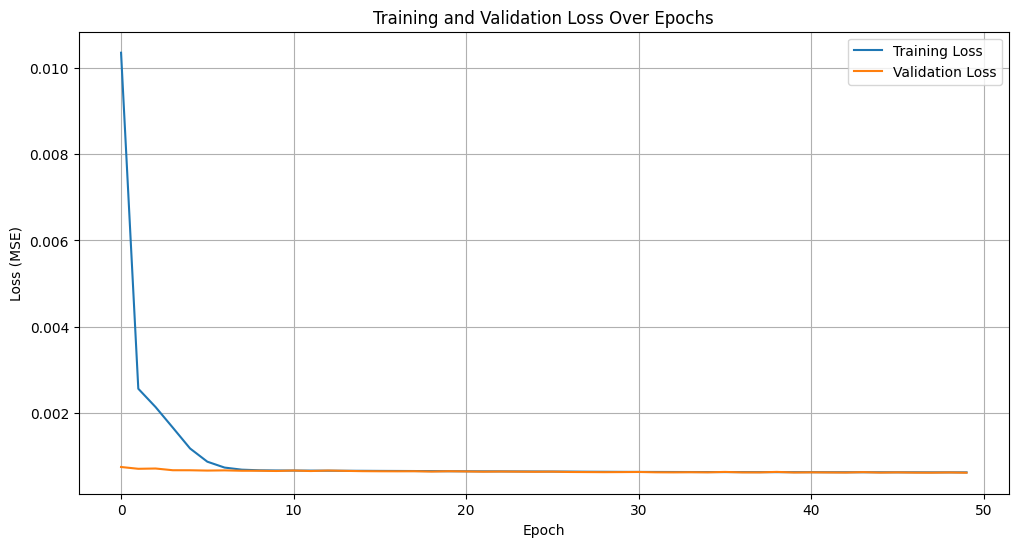

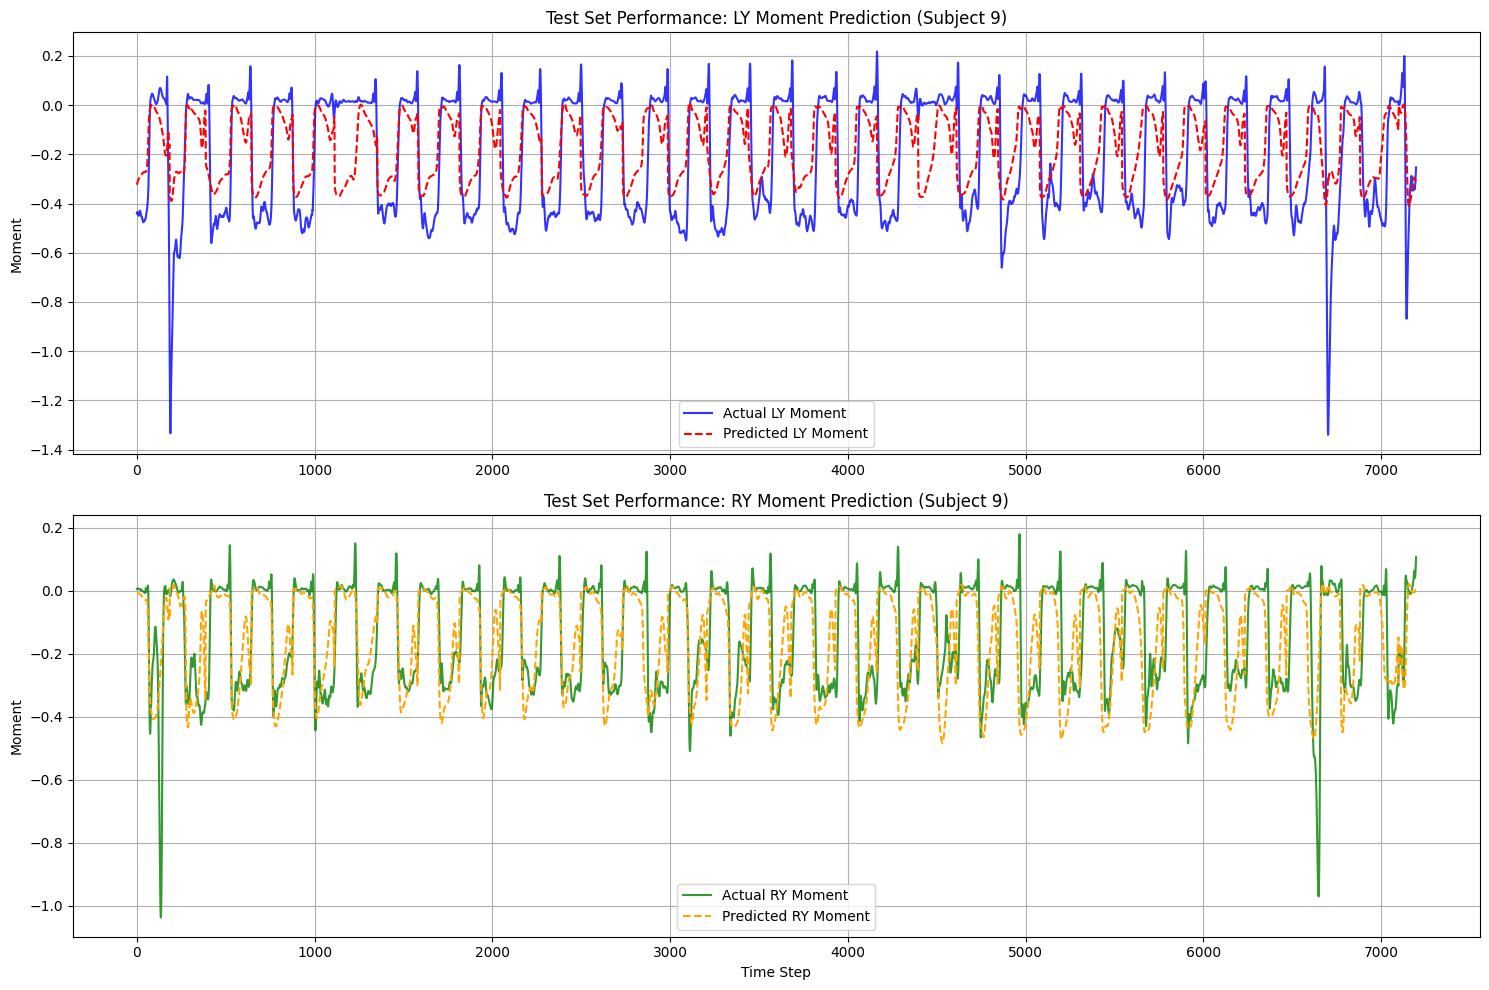

In [12]:
# --- Final Evaluation ---
if best_model_state is not None:
    # Assume feature_scaler, target_scaler, model, history, SUBJECT_TO_LEAVE_OUT, DATA_DIR, seq_length, step, test_trial_data are defined from previous cells
    
    # Function to create sequences for a single trial
    def create_sequences(features, targets, seq_length, step=1):
        sequences = []
        target_seq = []
        for i in range(0, len(features) - seq_length + 1, step):
            sequences.append(features[i:i + seq_length])
            target_seq.append(targets[i + seq_length - 1])
        return np.array(sequences), np.array(target_seq)

    model.eval()
    
    n_trials = len(test_trial_data)
    print(f"Test subject has {n_trials} trials. Evaluating all trials.")

    all_predictions = []
    all_ground_truth = []
    results_list = []  # To collect per-sequence data with trial info for CSV
    
    with torch.no_grad():
        for trial_idx, (acc_data, moment_data) in tqdm(enumerate(test_trial_data), total=n_trials, desc="Evaluating on Test Trials"):
            # Scale features and targets
            features_scaled = feature_scaler.transform(acc_data)
            targets_scaled = target_scaler.transform(moment_data)
            
            # Create sequences
            X_seq, y_seq = create_sequences(features_scaled, targets_scaled, seq_length, step)
            X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)
            
            # Batch prediction for the trial (efficient evaluation)
            trial_predictions = model(X_tensor).cpu().numpy()
            trial_ground_truth = y_tensor.cpu().numpy()
            
            all_predictions.append(trial_predictions)
            all_ground_truth.append(trial_ground_truth)
            
            # Rescale for this trial and add to results_list
            predictions_rescaled_trial = target_scaler.inverse_transform(trial_predictions)
            ground_truth_rescaled_trial = target_scaler.inverse_transform(trial_ground_truth)
            
            for i in range(len(predictions_rescaled_trial)):
                results_list.append({
                    'Trial': trial_idx,
                    'Actual_LY_Moment': ground_truth_rescaled_trial[i, 0],
                    'Predicted_LY_Moment': predictions_rescaled_trial[i, 0],
                    'Actual_RY_Moment': ground_truth_rescaled_trial[i, 1],
                    'Predicted_RY_Moment': predictions_rescaled_trial[i, 1]
                })

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_ground_truth = np.concatenate(all_ground_truth, axis=0)

    # Rescale predictions and ground truth back to original units (for metrics and plotting)
    predictions_rescaled = target_scaler.inverse_transform(all_predictions)
    ground_truth_rescaled = target_scaler.inverse_transform(all_ground_truth)

    # Calculate performance metrics
    mse = mean_squared_error(ground_truth_rescaled, predictions_rescaled)
    r2 = r2_score(ground_truth_rescaled, predictions_rescaled)
    print(f'--- Test Set Performance (Subject {SUBJECT_TO_LEAVE_OUT}) ---')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')

    # --- Save predictions to CSV with trial info ---
    results_df = pd.DataFrame(results_list)
    results_filename = f'predictions_for_subj_{SUBJECT_TO_LEAVE_OUT}.csv'
    results_df.to_csv(results_filename, index=False)
    print(f'Predictions saved to {results_filename}')

    # --- Plot training history ---
    plt.figure(figsize=(12, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

    # --- Visualize predictions vs. ground truth on a sample from the test set ---
    plot_len = min(7198, len(ground_truth_rescaled)) # Plot up to 1000 points
    time_steps = np.arange(plot_len)

    plt.figure(figsize=(15, 10))
    # Plot LY Moment
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, ground_truth_rescaled[:plot_len, 0], label='Actual LY Moment', color='blue', alpha=0.8)
    plt.plot(time_steps, predictions_rescaled[:plot_len, 0], label='Predicted LY Moment', color='red', linestyle='--')
    plt.title(f'Test Set Performance: LY Moment Prediction (Subject {SUBJECT_TO_LEAVE_OUT})')
    plt.ylabel('Moment')
    plt.legend()
    plt.grid(True)

    # Plot RY Moment
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, ground_truth_rescaled[:plot_len, 1], label='Actual RY Moment', color='green', alpha=0.8)
    plt.plot(time_steps, predictions_rescaled[:plot_len, 1], label='Predicted RY Moment', color='orange', linestyle='--')
    plt.title(f'Test Set Performance: RY Moment Prediction (Subject {SUBJECT_TO_LEAVE_OUT})')
    plt.xlabel('Time Step')
    plt.ylabel('Moment')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'test_set_predictions_subj_{SUBJECT_TO_LEAVE_OUT}.png')
    plt.show()
else:
    print('No model was trained, skipping evaluation.')